# LSTM - By Industry

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import datetime

In [2]:
# Import learning model dependencies
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

In [3]:
# Establish connection to AWS server
from config import db_password
import psycopg2
connection = psycopg2.connect(
    host = 'launch-it-1.cyo6pvehqvyz.us-east-1.rds.amazonaws.com',
    port = 5432,
    user = 'postgres',
    password = db_password,
    database='launch-it-1'
    )
cursor=connection.cursor()

In [4]:
# Pull SQL dataset from database
sql = """
SELECT * FROM launchit  
"""

# Build dataframe from SQL data
stock_data = pd.read_sql(sql, con=connection)
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,TCKR
0,2019-12-31,87.300003,87.300003,64.904999,71.699997,71.699997,33947.0,MKDTY
1,2020-01-02,72.900002,72.900002,62.250000,65.550003,65.550003,13607.0,MKDTY
2,2020-01-03,63.299999,66.750000,63.299999,65.250000,65.250000,4427.0,MKDTY
3,2020-01-06,65.550003,72.000000,63.750000,67.650002,67.650002,9933.0,MKDTY
4,2020-01-07,68.250000,72.419998,68.099998,72.000000,72.000000,8347.0,MKDTY


In [5]:
# Pull SQL dataset from database
sql = """
SELECT * FROM launchit_info 
"""

# Build dataframe from SQL data
info_data = pd.read_sql(sql, con=connection)
info_data.head()

,TCKR,sector,industry,country,growth_rate,debtToEquity,currentRatio,forwardPE
0,MKDTY,Basic Materials,Chemicals,China,-0.671,NaN,0.928,NaN
1,INDO,Energy,Oil & Gas E&P,Indonesia,1.206,12.272,2.707,-10.130434
2,MNPR,Healthcare,Biotechnology,United States,NaN,0.228,7.614,-2.526786
3,OCFT,Technology,Software—Application,China,0.172,12.583,1.223,-3.610476
4,SPT,Technology,Software—Application,United States,0.330,16.084,1.886,-3448.500200


In [6]:
# Merge the stock_data and info_data
data_all = stock_data.merge(info_data, how='left', left_on='TCKR', right_on='TCKR')
data_all

,Date,Open,High,Low,Close,Adj Close,Volume,TCKR,sector,industry,country,growth_rate,debtToEquity,currentRatio,forwardPE
0,2019-12-31,87.300003,87.300003,64.904999,71.699997,71.699997,33947.0,MKDTY,Basic Materials,Chemicals,China,-0.671,NaN,0.928,NaN
1,2020-01-02,72.900002,72.900002,62.250000,65.550003,65.550003,13607.0,MKDTY,Basic Materials,Chemicals,China,-0.671,NaN,0.928,NaN
2,2020-01-03,63.299999,66.750000,63.299999,65.250000,65.250000,4427.0,MKDTY,Basic Materials,Chemicals,China,-0.671,NaN,0.928,NaN
3,2020-01-06,65.550003,72.000000,63.750000,67.650002,67.650002,9933.0,MKDTY,Basic Materials,Chemicals,China,-0.671,NaN,0.928,NaN
4,2020-01-07,68.250000,72.419998,68.099998,72.000000,72.000000,8347.0,MKDTY,Basic Materials,Chemicals,China,-0.671,NaN,0.928,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670042,2022-11-04,10.230000,10.230000,10.230000,10.230000,10.230000,20000.0,CITE,Financial Services,Shell Companies,United States,NaN,NaN,11.252,NaN
670043,2022-11-07,10.235000,10.250000,10.235000,10.250000,10.250000,27500.0,CITE,Financial Services,Shell Companies,United States,NaN,NaN,11.252,NaN
670044,2022-11-08,10.270000,10.270000,10.270000,10.270000,10.270000,1500.0,CITE,Financial Services,Shell Companies,United States,NaN,NaN,11.252,NaN
670045,2022-11-09,10.260000,10.260000,10.230000,10.230000,10.230000,3500.0,CITE,Financial Services,Shell Companies,United States,NaN,NaN,11.252,NaN


In [7]:
data_all = data_all.set_index(['Date' , 'industry'])
data_all

,,Open,High,Low,Close,Adj Close,Volume,TCKR,sector,country,growth_rate,debtToEquity,currentRatio,forwardPE
Date,industry,,,,,,,,,,,,,
2019-12-31,Chemicals,87.300003,87.300003,64.904999,71.699997,71.699997,33947.0,MKDTY,Basic Materials,China,-0.671,NaN,0.928,NaN
2020-01-02,Chemicals,72.900002,72.900002,62.250000,65.550003,65.550003,13607.0,MKDTY,Basic Materials,China,-0.671,NaN,0.928,NaN
2020-01-03,Chemicals,63.299999,66.750000,63.299999,65.250000,65.250000,4427.0,MKDTY,Basic Materials,China,-0.671,NaN,0.928,NaN
2020-01-06,Chemicals,65.550003,72.000000,63.750000,67.650002,67.650002,9933.0,MKDTY,Basic Materials,China,-0.671,NaN,0.928,NaN
2020-01-07,Chemicals,68.250000,72.419998,68.099998,72.000000,72.000000,8347.0,MKDTY,Basic Materials,China,-0.671,NaN,0.928,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-04,Shell Companies,10.230000,10.230000,10.230000,10.230000,10.230000,20000.0,CITE,Financial Services,United States,NaN,NaN,11.252,NaN
2022-11-07,Shell Companies,10.235000,10.250000,10.235000,10.250000,10.250000,27500.0,CITE,Financial Services,United States,NaN,NaN,11.252,NaN
2022-11-08,Shell Companies,10.270000,10.270000,10.270000,10.270000,10.270000,1500.0,CITE,Financial Services,United States,NaN,NaN,11.252,NaN


In [8]:
# List all of the column names
data_all.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'TCKR', 'sector',
       'country', 'growth_rate', 'debtToEquity', 'currentRatio', 'forwardPE'],
      dtype='object')

In [9]:
# Create a new data frame grouped by Industry and taking the median of numeric values

# Make a new copy of the data_all 
industry_data = data_all.copy()

# Drop unneeded columns
industry_data = industry_data.drop(labels=['TCKR', 'sector', 'country', 'growth_rate', 'debtToEquity',
       'currentRatio', 'forwardPE'], axis=1)

# sort the data using sort_index()
industry_data.sort_index()
industry_data

,,Open,High,Low,Close,Adj Close,Volume
Date,industry,,,,,,
2019-12-31,Chemicals,87.300003,87.300003,64.904999,71.699997,71.699997,33947.0
2020-01-02,Chemicals,72.900002,72.900002,62.250000,65.550003,65.550003,13607.0
2020-01-03,Chemicals,63.299999,66.750000,63.299999,65.250000,65.250000,4427.0
2020-01-06,Chemicals,65.550003,72.000000,63.750000,67.650002,67.650002,9933.0
2020-01-07,Chemicals,68.250000,72.419998,68.099998,72.000000,72.000000,8347.0
...,...,...,...,...,...,...,...
2022-11-04,Shell Companies,10.230000,10.230000,10.230000,10.230000,10.230000,20000.0
2022-11-07,Shell Companies,10.235000,10.250000,10.235000,10.250000,10.250000,27500.0
2022-11-08,Shell Companies,10.270000,10.270000,10.270000,10.270000,10.270000,1500.0


In [10]:
# Group by Industry and take the median of all numeric values
# industry_data = industry_data.groupby(level='Date').median()

industry_data = industry_data.groupby(level=[0,1]).median()
industry_data

Open       High        Low  \
Date       industry                                                     
1992-05-21 Software—Infrastructure    20.000000  20.000000  17.750000   
1992-05-22 Software—Infrastructure    18.000000  18.500000  18.000000   
1992-05-26 Software—Infrastructure    18.000000  18.500000  16.500000   
1992-05-27 Software—Infrastructure    17.500000  17.500000  16.000000   
1992-05-28 Software—Infrastructure    16.500000  17.500000  16.500000   
...                                         ...        ...        ...   
2022-11-11 Utilities—Diversified      11.760000  12.575000  11.560000   
           Utilities—Regulated Gas    50.480000  54.223400  50.250000   
           Utilities—Regulated Water  16.040001  17.620001  16.204901   
           Utilities—Renewable         9.830000  10.012500   9.405000   
           Waste Management           33.585000  38.557500  36.761950   

                                          Close  Adj Close     Volume  
Date       industry                                                    
1992-05-21 Software—Infrastructure    18.000000  18.000000   248200.0  
1992-05-22 Software—Infrastructure    18.000000  18.000000    69150.0  
1992-05-26 Software—Infrastructure    17.000000  17.000000    84700.0  
1992-05-27 Software—Infrastructure    17.000000  17.000000    17300.0  
1992-05-28 Software—Infrastructure    17.000000  17.000000    40200.0  
...                                         ...        ...        ...  
2022-11-11 Utilities—Diversified      12.290000  12.290000   908535.0  
           Utilities—Regulated Gas    50.599998  50.599998  6621946.0  
           Utilities—Regulated Water  17.540001  17.540001   242921.0  
           Utilities—Renewable         9.460000   9.460000   302936.5  
           Waste Management           38.085001  38.085001  1126555.5  

[89132 rows x 6 columns]

In [11]:
industry_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [12]:
# # Create a function to run the LSTM learning model for each industry
# def learning_model(df):
#     # download the data
#     y = df['Adj Close'].fillna(method='ffill')
#     y = y.values.reshape(-1, 1)

#     # scale the data
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaler = scaler.fit(y)
#     y = scaler.transform(y)

#     # generate the input and output sequences
#     n_lookback = 365  # length of input sequences (lookback period)
#     n_forecast = 180  # length of output sequences (forecast period)

#     X = []
#     Y = []

#     for i in range(n_lookback, len(y) - n_forecast + 1):
#         X.append(y[i - n_lookback: i])
#         Y.append(y[i: i + n_forecast])

#     X = np.array(X)
#     Y = np.array(Y)

#     # fit the model
#     model = Sequential()
#     model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
#     model.add(LSTM(units=50))
#     model.add(Dense(n_forecast))

#     model.compile(loss='mean_squared_error', optimizer='adam')
#     model.fit(X, Y, epochs=3, batch_size=32, verbose=0)

#     # generate the forecasts
#     X_ = y[- n_lookback:]  # last available input sequence
#     X_ = X_.reshape(1, n_lookback, 1)

#     Y_ = model.predict(X_).reshape(-1, 1)
#     Y_ = scaler.inverse_transform(Y_)

#     # organize the results in a data frame
#     df_past = df[['Close']].reset_index()
#     df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
#     df_past['Date'] = pd.to_datetime(df_past['Date'])
#     df_past['Forecast'] = np.nan
#     df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

#     df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
#     df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
#     df_future['Forecast'] = Y_.flatten()
#     df_future['Actual'] = np.nan

#     results = df_past.append(df_future).set_index('Date')
    
#     # Calculate rate of return on investment based on projected future stock price
#     return_rate = (results['Forecast'][-1] - df['Adj Close'][-1]) / df['Adj Close'][-1]
    
#     return return_rate

#     # plot the results - optional
#     #results.plot(title='VIST', figsize=(16,8))

In [13]:
# # Run learning_model on industry dataframe
# learning_model(industry_data)

In [14]:
# Isolate just 1 Industry to attempt LSTM process
df = industry_data.filter(like = 'Software—Infrastructure', axis=0)
df

,,Open,High,Low,Close,Adj Close,Volume
Date,industry,,,,,,
1992-05-21,Software—Infrastructure,20.00,20.00000,17.750,18.000,18.000,248200.0
1992-05-22,Software—Infrastructure,18.00,18.50000,18.000,18.000,18.000,69150.0
1992-05-26,Software—Infrastructure,18.00,18.50000,16.500,17.000,17.000,84700.0
1992-05-27,Software—Infrastructure,17.50,17.50000,16.000,17.000,17.000,17300.0
1992-05-28,Software—Infrastructure,16.50,17.50000,16.500,17.000,17.000,40200.0
...,...,...,...,...,...,...,...
2022-11-07,Software—Infrastructure,11.00,11.20000,10.740,11.010,11.010,858900.0
2022-11-08,Software—Infrastructure,11.15,11.68500,10.330,10.920,10.920,1054500.0
2022-11-09,Software—Infrastructure,10.74,10.96500,10.470,10.550,10.550,766800.0


In [16]:
# Reset the index
df.reset_index(inplace=True)

# Drop the industry column
df = df.drop(labels=['industry'], axis=1)

# Set the date column as the index
df = df.set_index('Date')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1992-05-21,20.00,20.00000,17.750,18.000,18.000,248200.0
1992-05-22,18.00,18.50000,18.000,18.000,18.000,69150.0
1992-05-26,18.00,18.50000,16.500,17.000,17.000,84700.0
1992-05-27,17.50,17.50000,16.000,17.000,17.000,17300.0
1992-05-28,16.50,17.50000,16.500,17.000,17.000,40200.0
...,...,...,...,...,...,...
2022-11-07,11.00,11.20000,10.740,11.010,11.010,858900.0
2022-11-08,11.15,11.68500,10.330,10.920,10.920,1054500.0
2022-11-09,10.74,10.96500,10.470,10.550,10.550,766800.0


1/1 [==============================] - 2s 2s/step


<AxesSubplot:title={'center':'Software-Infrastructure'}, xlabel='Date'>

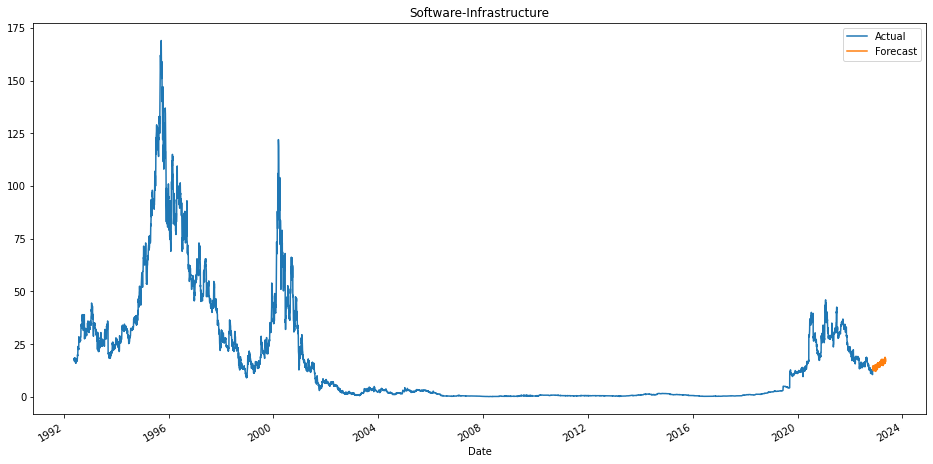

In [17]:
# download the data
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 365  # length of input sequences (lookback period)
n_forecast = 180  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=3, batch_size=32, verbose=0)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title='Software-Infrastructure', figsize=(16,8))